In [1]:
from collections import defaultdict
from dataclasses import dataclass

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import qctrlvisualizer as qv
import qutip as qt
from jax.scipy.linalg import expm
from scipy.optimize import minimize

jax.config.update("jax_enable_x64", True)


@dataclass
class OptimizationResult:
    _result: any
    times: npt.NDArray[np.float64]
    params: npt.NDArray[np.float64]
    pulse: npt.NDArray[np.complex128]

    def plot(self):
        pulse = np.append(self.pulse, self.pulse[-1])
        plt.step(self.times, np.real(pulse), where="post", label="I")
        plt.step(self.times, np.imag(pulse), where="post", label="Q")
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()


@dataclass
class SimulationResult:
    dimension: int
    times: npt.NDArray[np.float64]
    unitaries: list[qt.Qobj]
    states: list[qt.Qobj]
    infidelities: list[float]

    def substates(self, index) -> list[qt.Qobj]:
        substates = [state.ptrace(index) for state in self.states]
        return substates

    def display_bloch_sphere(self, index):
        rho = np.array(self.substates(index)).squeeze()[:, :2, :2]
        qv.display_bloch_sphere_from_density_matrices(rho)

    def plot_populations(self):
        d = self.dimension
        basis = list(np.ndindex(d, d))
        populations = defaultdict(list)
        for state in self.states:
            state = qt.ket2dm(state)
            population = state.diag()
            population = np.clip(population, 0, 1)
            for idx, prob in enumerate(population):
                label = "".join(str(i) for i in basis[idx])
                populations[rf"$|{label}\rangle$"].append(prob)
        qv.plot_population_dynamics(
            self.times,
            populations,
            figure=plt.figure(),
        )

    def plot_sub_populations(self, index):
        populations = defaultdict(list)
        for state in self.substates(index):
            population = state.diag()
            population = np.clip(population, 0, 1)
            for idx, prob in enumerate(population):
                populations[rf"$|{idx}\rangle$"].append(prob)
        qv.plot_population_dynamics(
            self.times,
            populations,
            figure=plt.figure(),
        )

    def plot_unitary_infidelities(self):
        plt.plot(self.times, self.infidelities)
        plt.grid(color="gray", linestyle="--", alpha=0.2)
        plt.ylim(0, 1)


class PulseOptimizer:
    def __init__(
        self,
        dimension: int,
        omega_0: float,
        omega_1: float,
        alpha_0: float,
        alpha_1: float,
        g: float,
        segment_count: int,
        segment_width: float,
        target_unitary: npt.NDArray[np.complex128],
    ):
        self.dimension = dimension
        self.total_dimension = dimension**2
        self.segment_count = segment_count
        self.segment_width = segment_width
        self.duration = segment_count * segment_width
        self.a_0 = qt.tensor(qt.destroy(dimension), qt.qeye(dimension)).full()
        self.ad_0 = self.a_0.conj().T
        self.H_sys = self.system_hamiltonian(omega_0, omega_1, alpha_0, alpha_1, g)
        self.initial_params = self.random_params()
        self.target_unitary = target_unitary
        self.jacobian = jax.jit(jax.grad(self.objective_function))

    def system_hamiltonian(
        self,
        omega_0: float,
        omega_1: float,
        alpha_0: float,
        alpha_1: float,
        g: float,
    ) -> npt.NDArray[np.complex128]:
        a_0 = self.a_0
        ad_0 = self.ad_0
        a_1 = qt.tensor(qt.qeye(self.dimension), qt.destroy(self.dimension)).full()
        ad_1 = a_1.conj().T
        H_0 = omega_0 * ad_0 @ a_0 + 0.5 * alpha_0 * ad_0 @ ad_0 @ a_0 @ a_0
        H_1 = omega_1 * ad_1 @ a_1 + 0.5 * alpha_1 * ad_1 @ ad_1 @ a_1 @ a_1
        H_int = g * (ad_0 @ a_1 + a_0 @ ad_1)
        H_sys = H_0 + H_1 + H_int
        return H_sys

    def pwc_unitary(
        self,
        value: complex,
        duration: float,
    ) -> npt.NDArray[np.complex128]:
        H_ctrl = 0.5 * (self.ad_0 * value + self.a_0 * jnp.conj(value))
        H = self.H_sys + H_ctrl
        U = expm(-1j * H * duration)
        return U

    def objective_function(
        self,
        params: npt.NDArray[np.float64],
    ) -> float:
        pulse = self.params_to_pulse(params)
        U = jnp.eye(self.total_dimension)
        for value in pulse:
            U = self.pwc_unitary(value, self.segment_width) @ U
        return self.unitary_infidelity(U, self.target_unitary)

    def unitary_infidelity(
        self,
        U1: npt.NDArray[np.complex128],
        U2: npt.NDArray[np.complex128],
    ) -> float:
        return 1 - jnp.abs((U1.conj().T @ U2).trace() / self.total_dimension) ** 2

    def random_params(
        self,
        key=0,
    ) -> npt.NDArray[np.float_]:
        key = jax.random.key(key)
        return jax.random.uniform(
            key=key,
            shape=(2 * self.segment_count,),
            dtype=np.float_,
            minval=-1,
            maxval=1,
        )

    def params_to_pulse(
        self,
        params: npt.NDArray[np.float64],
    ) -> npt.NDArray[np.complex128]:
        params = params.reshape((self.segment_count, 2))
        return params[:, 0] + 1j * params[:, 1]

    def optimize(
        self,
    ) -> OptimizationResult:
        result = minimize(
            self.objective_function,
            self.initial_params,
            method="BFGS",
            jac=self.jacobian,
        )
        params = np.array(result.x, dtype=np.float_)
        pulse = self.params_to_pulse(params)
        times = np.linspace(0, self.duration, self.segment_count + 1, dtype=np.float_)
        return OptimizationResult(
            _result=result,
            times=times,
            params=params,
            pulse=pulse,
        )

    def simulate(
        self,
        pulse: npt.NDArray[np.complex128],
        steps_per_segment: int,
    ) -> SimulationResult:
        pulse = np.repeat(pulse, steps_per_segment)
        segment_count = self.segment_count * steps_per_segment
        times = np.linspace(0, self.duration, segment_count + 1)
        dimension = self.dimension
        unitaries = [qt.tensor(qt.qeye(dimension), qt.qeye(dimension))]
        initail_state = qt.tensor(qt.basis(dimension, 0), qt.basis(dimension, 0))
        states = [initail_state]
        infidelities = [0.0]
        segment_width = self.segment_width / steps_per_segment
        for value in pulse:
            unitary = np.array(self.pwc_unitary(value, segment_width))
            U = qt.Qobj(unitary, dims=[[dimension] * 2] * 2) * unitaries[-1]
            unitaries.append(U)
            state = U * states[0]
            states.append(state)
            infidelity = self.unitary_infidelity(U.full(), self.target_unitary)
            infidelities.append(infidelity)
        return SimulationResult(
            dimension=self.dimension,
            times=times,
            unitaries=unitaries,
            states=states,
            infidelities=infidelities,
        )

In [2]:
U_0 = qt.Qobj(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)

U_1 = qt.Qobj(
    [
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
    ]
)

target_unitary = qt.tensor(U_0, U_1)
target_unitary

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [3]:
# target_unitary = qt.tensor(qt.rand_unitary_haar(3), qt.rand_unitary_haar(3))
# target_unitary

# target_unitary = qt.rand_unitary_haar(9)
# target_unitary

In [4]:
optimizer = PulseOptimizer(
    dimension=3,
    omega_0=0.0 * 2 * np.pi,
    omega_1=0.002 * 2 * np.pi,
    alpha_0=-0.3 * 2 * np.pi,
    alpha_1=-0.3 * 2 * np.pi,
    g=0.01 * 2 * np.pi,
    segment_count=50,
    segment_width=10.0,
    target_unitary=target_unitary.full(),
)

In [5]:
target_unitary.dag() * target_unitary

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [6]:
opt_result = optimizer.optimize()
opt_result

OptimizationResult(_result=      fun: 5.1103565823495956e-11
 hess_inv: array([[ 1.11121770e+00,  1.47746431e+00,  1.74981106e-01, ...,
        -4.09930088e-01,  7.75369076e-01,  4.50043459e-01],
       [ 1.47746431e+00,  2.63453443e+00,  9.87678693e-02, ...,
        -9.71944568e-01,  9.83618774e-01,  7.55822731e-01],
       [ 1.74981106e-01,  9.87678693e-02,  1.06769483e+00, ...,
         5.49313522e-01,  8.37748473e-02,  1.58599808e-03],
       ...,
       [-4.09930088e-01, -9.71944568e-01,  5.49313522e-01, ...,
         3.59343769e+00, -7.52271518e-01, -7.45613566e-01],
       [ 7.75369076e-01,  9.83618774e-01,  8.37748473e-02, ...,
        -7.52271518e-01,  2.85913905e+00,  1.32863487e+00],
       [ 4.50043459e-01,  7.55822731e-01,  1.58599808e-03, ...,
        -7.45613566e-01,  1.32863487e+00,  9.52649958e-01]])
      jac: array([ 1.72154113e-06, -1.34552418e-06,  1.18957669e-06, -1.19094006e-06,
        7.30443441e-07, -4.12116405e-07, -3.30148055e-06, -2.64928752e-06,
        1.

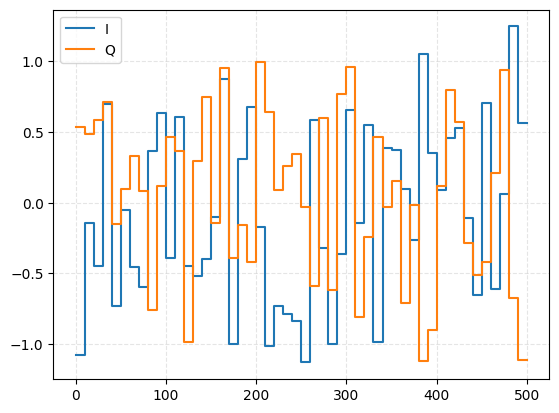

In [7]:
opt_result.plot()

In [8]:
sim_result = optimizer.simulate(
    pulse=opt_result.pulse,
    steps_per_segment=30,
)

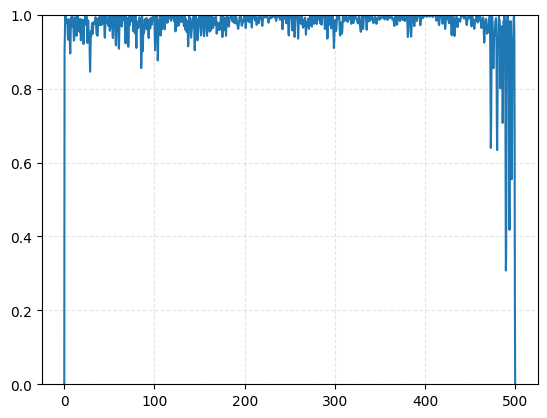

In [9]:
sim_result.plot_unitary_infidelities()

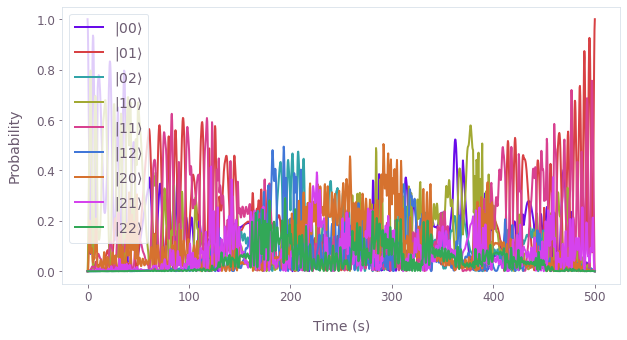

In [10]:
sim_result.plot_populations()

In [11]:
sim_result.display_bloch_sphere(0)

<IPython.core.display.Javascript object>

In [12]:
sim_result.display_bloch_sphere(1)

<IPython.core.display.Javascript object>